In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#experimental
from numba import jit,vectorize, float64
from IPython.core.pylabtools import figsize
figsize(14.5,5)

In [2]:
class NN(object):
    def __init__(self,parameters):
                #Expect parameters to be a tuple of the form:
        #    ((n_input,0,0), (n_hidden_layer_1, f_1, f_1'), ...,
        #     (n_hidden_layer_k, f_k, f_k'), (n_output, f_o, f_o'))
        self.n_layers = len(parameters)
        self.sizes = [layer[0] for layer in parameters]
        self.fs = [layer[1] for layer in parameters]
        self.fprimes = [layer[2] for layer in parameters]
        self.dropout_p = [layer[3] for layer in parameters]
        self.weight_decay = .0001

        self.build_network()
        
        
    def build_network(self,ass_weights=True):
        self.weights = []
        self.biases = []
        self.inputs = []
        self.outputs = []
        self.errors = []
        self.dropout = []
        self.dropout_weights = []
        
        #initialize weights; but not the last one (we don't need a last weight matrix)
        for layer in range(self.n_layers -1):
            #size of weight matrices
            n = self.sizes[layer] #input
            m = self.sizes[layer+1] # output
            if ass_weights == True:
                self.weights.append(2*np.random.random((m,n))-1)
            else:
                self.weights.append(np.random.normal(0,1,(m,n)))
            self.dropout_weights.append(np.zeros((m,n)))
            self.biases.append(np.random.normal(0,1,(m,1)))
            self.inputs.append(np.zeros((n,1)))
            self.outputs.append(np.zeros((n,1)))
            self.errors.append(np.zeros((n,1)))
            self.dropout.append(np.ones((n,1)))
        #get input, output and error for last layer that doesn't need weight matrix    
        n = self.sizes[-1]
        self.inputs.append(np.zeros((n,1)))
        self.outputs.append(np.zeros((n,1)))
        self.errors.append(np.zeros((n,1)))
        self.dropout.append(np.ones((n,1)))

        
    def feedforward(self, x,dropout=True,weights=True):
        #Propagates the input from the input layer to the output layer.
        k=len(x)
        x.shape=(k,1)
        self.inputs[0]=x
        self.outputs[0]=x
        if dropout == True:
            for i in range(1,self.n_layers):
                dropout = np.random.binomial(1,1-self.dropout_p[i],size = self.weights[i-1].shape)
                dropout = dropout.astype(bool)
                weights_tmp = self.weights[i-1].copy()
                weights_tmp[~dropout] = 0
                self.dropout_weights[i-1] = weights_tmp
                self.inputs[i]=weights_tmp.dot(self.outputs[i-1])+self.biases[i-1]
                self.outputs[i]=self.fs[i](self.inputs[i])
           
        else:
            for i in range(1,self.n_layers):
                self.inputs[i]=self.weights[i-1].dot(self.outputs[i-1]
                                                    )+self.biases[i-1]
                self.outputs[i]=self.fs[i](self.inputs[i])
            
            
        
        return self.outputs[-1]
    
    
    def update_weights(self,x,y,dropout = False):
        output = self.feedforward(x,dropout)

        self.errors[-1] = self.fprimes[-1](self.outputs[-1])*(output-y)
        
        
        #first and last layer gone
        n = self.n_layers-2
        if 1==2:
            pass
        else:                                
            for i in range(n,0,-1):
                self.errors[i] = self.fprimes[i](self.inputs[i]
                                 )*self.weights[i].T.dot(self.errors[i+1])

                self.weights[i] = self.weights[i]-self.learning_rate*np.outer(
                    self.errors[i+1],self.outputs[i]
                ) -self.learning_rate*self.weight_decay*self.weights[i]
                self.biases[i] = self.biases[i] - self.learning_rate*self.errors[i+1]
            self.weights[0] = self.weights[0] - self.learning_rate*np.outer(self.errors[1],self.outputs[0])
            self.biases[0] = self.biases[0] - self.learning_rate*self.errors[1]

        
        
    def train(self,X,y,n_iter,learning_rate=1,shuffle = True,plot=False,dropout=True):
        self.learning_rate = learning_rate
        n = X.shape[0]
        for repeat in range(n_iter):
            #shuffle
            index = list(range(n))
            if shuffle ==True:
                np.random.shuffle(index)
            for row in index:
                x_i = X[row]
                y_i = y[row]
                self.update_weights(x_i,y_i,dropout)


    def predict_x(self,x):
        return self.feedforward(x,False)
    
    def predict(self,X,dropout = False):
        n = len(X)
        m = self.sizes[-1]
        ret = np.ones((n,m))
        for i in range(len(X)):
            ret[i,:] = self.feedforward(X[i],dropout)

        return ret
    
    
    
    def calculate_uncertainty(self,num_reps,X=None):
        if X == None:
            n=100
            X=np.linspace(0,3*np.pi,num=n)
            print(X)
        else:
            try:
                n = len(X)
            except:
                X = np.array([X])
                n = 1
        pred_mean = []
        pred_var = []
        for i in range(len(X)):
            safe_vals = []
            for rep in range(num_reps):
                #ret[i,:] = self.feedforward(X[i],True)
                safe_vals.append(self.feedforward(X[i],True))
            pred_mean.append(np.mean(safe_vals))#,axis=0))
            tau = 10**2*(1-max(self.dropout_p))/(2*n*self.weight_decay)
            pred_var.append(np.var(safe_vals))#,axis=0)*tau)
            
        return np.array(pred_mean),np.array(pred_var)*tau**-1
    
    
    def calc_unc(self,sample_num,X):
        try:
            n = len(X)
        except:
            X = np.array([X]) # will this work?!
            n = 1
                
            
        mean_arr = np.ones(shape=X.shape[0])
        var_arr = np.ones(shape=X.shape[0])
        for i in range(n):
            samples = []
            for j in range(sample_num):
                samples += [self.feedforward(X[i],True)]
            mean_arr[i] = np.mean(samples)
            var_arr[i] = np.var(samples)
            
        return mean_arr, var_arr
                
            
                
                
    

In [3]:
@jit(nopython=True)
def logistic(x):
    return 1.0/(1+np.exp(-x))

@jit(nopython=True)
def logistic_prime(x):
    ex=np.exp(-x)
    return ex/(1+ex)**2

@jit(nopython=True)
def identity(x):
    return x
 
@jit(nopython=True)
def identity_prime(x):
    return 1

@jit(nopython=True)
def tanh(x):
    ex= np.exp(x)
    ex_neg = np.exp(-x)
    return(ex-ex_neg)/(ex+ex_neg)

@jit(nopython=True)
def tanh_prime(x):
    ex= np.exp(x)
    ex_neg = np.exp(-x)
    return 2/(ex+ex_neg)
#expic computes logistics fast.
from scipy.special import expit

def softplus(x):
    return np.log(1+np.exp(x))

def softplus_prime(x):
    return logistic(x)


def relu(x):
    return np.log(np.max([0.000000001,x]))

def relu_prime(x):
    return np.sign(x)
param=((1,0,0),(20, expit, logistic_prime),(20, expit, logistic_prime),(1,identity, identity_prime))



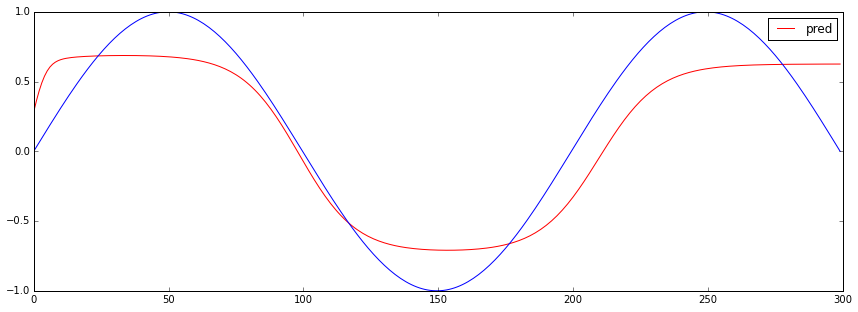

In [17]:
rate = .05#.05
func = expit#tanh#expit#tanh
func_prime = logistic_prime#tanh_prime
param=(
    (1,0,0,0),
    (12, func, func_prime,0.1),#######
       #(8, func, func_prime,0.2),######
       #(22, func, func_prime,0.2),######
       ###(10, func, func_prime,0.1),######
       #(4, func, func_prime,0.0),######

       (1,identity, identity_prime,0))



n=300
X=np.linspace(0,3*np.pi,num=n)
X.shape=(n,1)
y=np.sin(X)
###y += np.random.normal(0,.2,size=y.shape)
N=NN(param)
N.train(X,y,700, learning_rate=rate,dropout=True) # now not trained on mask!

plt.plot(N.predict(X),color='r',label='pred')
#plt.plot(N_tmp.predict(X))
plt.plot(y)
plt.legend()

C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:128: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


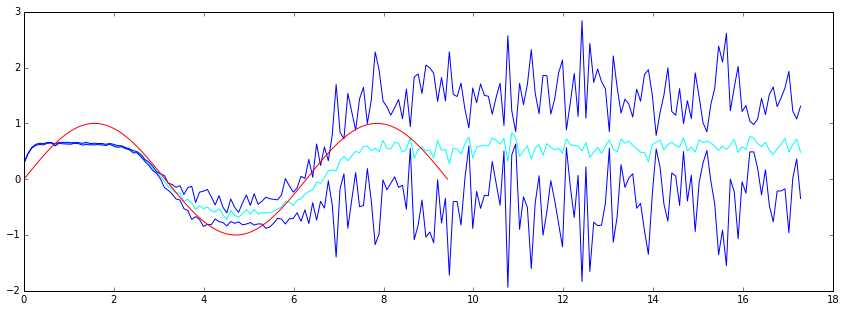

In [18]:
X_test=np.linspace(0,5.5*np.pi,num=200)
X_test.shape=(200,1)

#X_test = X
#X_test = np.atleast_2d(X_test)

#X_test = 

m,s = N.calculate_uncertainty(20,X_test)

plt.plot(X_test,m,color='cyan')
plt.plot(X_test,np.array(m)+s*10**4,color='blue')
plt.plot(X_test,m-s*10**4,color = 'blue')
plt.plot(X,y,color='red')


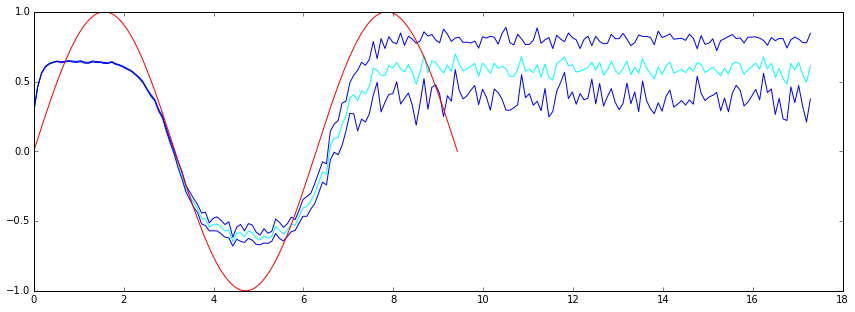

In [19]:
m,s = N.calc_unc(100,X_test)

plt.plot(X_test,m,color='cyan')
plt.plot(X_test,np.array(m)+s*1,color='blue')
plt.plot(X_test,np.array(m)-s*1,color = 'blue')
plt.plot(X,y,color='red')


# next test
from sklearn.datasets.samples_generator import make_regression


In [20]:
from sklearn.datasets.samples_generator import make_regression


In [21]:
y = 10+3*X+np.random.normal(0,1,size=X.shape)

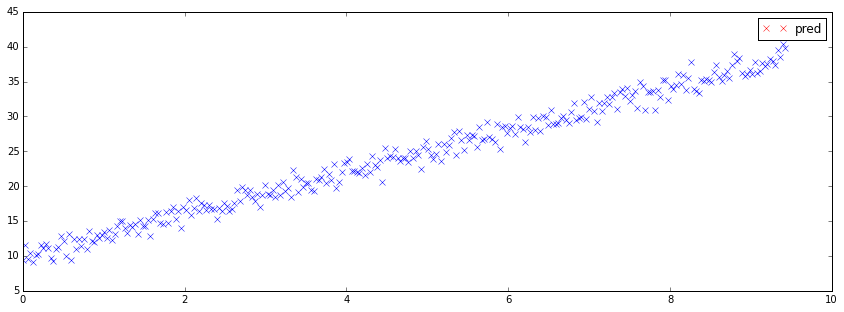

In [28]:
rate = .1#.05
func = tanh#expit#tanh
func_prime = tanh_prime#logistic_prime#tanh_prime
param=(
    (1,0,0,0),
    #(12, func, func_prime,0),#######
       #(15, func, func_prime,0.2),######
       #(22, func, func_prime,0.2),######
       (6, func, func_prime,0.1),######
       (1,identity, identity_prime,0))

nn=NN(param)
nn.train(X,y,100, learning_rate=rate,dropout=True) # now not trained on mask!

plt.plot(X,nn.predict(X),'x',color='r',label='pred')
#plt.plot(N_tmp.predict(X))
plt.plot(X,y,'x')
plt.legend()

In [29]:
X.shape,y.shape,m.shape

((300, 1), (300, 1), (200,))

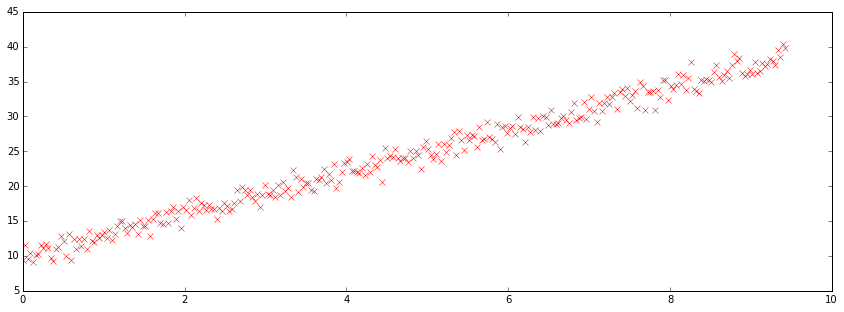

In [30]:

m,s = nn.calc_unc(100,X_test)

plt.plot(X_test,m,'x',color='cyan')
plt.plot(X_test,np.array(m)+s,color='blue')
plt.plot(X_test,m-s,color = 'blue')
plt.plot(X,y,'x',color='red')
